In [318]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
nltk.download('punkt')
nltk.download('stopwords')
from nltk.probability import FreqDist

[nltk_data] Downloading package punkt to /Users/yangrchen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yangrchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [319]:
df = pd.read_csv('../data/MSA2024_TIPS_Data.csv')
df = df.set_axis(['1', '2', '3', '4', 'year'], axis=1)
df.head()

,1,2,3,4,year
0,Keep in mind before the class: where have we b...,Remember to clean the kitchen,NaN,NaN,2023
1,prioritize life outside of the IAA so you don'...,NaN,start the data visualization project way earli...,NaN,2023
2,"When they say ""trust the process,"" you actuall...",you are expected to maintain an A/B grade poin...,"Fall 2 is the most stressful, fast-paced semes...",Don't worry about the TIPS project so much. It...,2023
3,when you are interested in an analytic group ...,If you are coming into the program after havin...,"Depending on your cohort, you may or may not m...","Put your mental health and relationships, abov...",2023
4,Take good care of yourself. Getting adequate s...,"Don't be shy to ask the faculty, classmates, T...",Hang out with your classmates during lunch or ...,It's useful to have prior knowledge of Python ...,2023


In [320]:
# Text pre-processing, remove stop words etc, lower case
# Plot Unigram, bigram, trigram frequencies for each year
# IMPORTANT: A 'token' is just a word. We call them tokens because not every item in a sentence is an english word... i.e.
# numbers, symbols, etc. When I split things into tokens, I am just breaking up the bigger string

# data structure looks like this
# years = {2016->2023}
# each year is list of lists containing the text tokens
# Replace the NaNs with empty string
df = df.replace(to_replace = np.nan, value = " ") 

In [321]:
years = df['year'].unique()
stop_words = stopwords.words('english')
stop_words.extend(["''", "``", "n't", "'s"])

def tokenize_and_clean(tip: str):
    tip_token = nltk.word_tokenize(tip.lower())
    clean_tip = [word for word in tip_token if word not in stop_words and word not in string.punctuation]
    return clean_tip

tokens_df = df.iloc[:, :-1].applymap(tokenize_and_clean)
tokens_df['year'] = df['year']

tokens_df.iloc[2]

1       [say, trust, process, actually, staff, faculty...
2       [expected, maintain, a/b, grade, point, averag...
3       [fall, 2, stressful, fast-paced, semester, get...
4       [worry, tips, project, much, purpose, see, wel...
year                                                 2023
Name: 2, dtype: object

In [322]:
def generate_n_gram(n: int) -> pd.DataFrame:
    n_gram_df = pd.DataFrame(columns=['gram', 'freq', 'year'])
    lst = []

    for year in years:
        words = []
        tokens_df[tokens_df['year'] == year].iloc[:, :-1].applymap(lambda x: words.extend(x))

        n_gram = list(nltk.ngrams(words, n))
        fdist = FreqDist(n_gram)

        # Panda's append is O(n) so we create a temp list
        for gram, freq in fdist.items():
            lst.append([gram, freq, year])

    n_gram_df = pd.concat([n_gram_df, pd.DataFrame(lst, columns=['gram', 'freq', 'year'])])
    n_gram_df['prob'] = n_gram_df['freq'] / n_gram_df['freq'].sum()

    return n_gram_df

unigram_df = generate_n_gram(1)
unigram_df[(unigram_df['gram'] == ('international',)) & (unigram_df['year'] == 2016)]

,gram,freq,year,prob
8099,"(international,)",3,2016,0.000122


In [323]:
test = generate_n_gram(4)
top = test[test['year'] == 2023].sort_values('prob', ascending=False)
top

,gram,freq,year,prob
1187,"(make, close, friends, program)",2,2023,0.000082
0,"(keep, mind, class, going)",1,2023,0.000041
2553,"(arise, team, first, assigned)",1,2023,0.000041
2541,"(months, closely, working, people)",1,2023,0.000041
2542,"(closely, working, people, unique)",1,2023,0.000041
...,...,...,...,...
1278,"(individuals, whole, program, opportunity)",1,2023,0.000041
1279,"(whole, program, opportunity, share)",1,2023,0.000041
1280,"(program, opportunity, share, know)",1,2023,0.000041
1281,"(opportunity, share, know, also)",1,2023,0.000041


<Axes: xlabel='gram', ylabel='prob'>

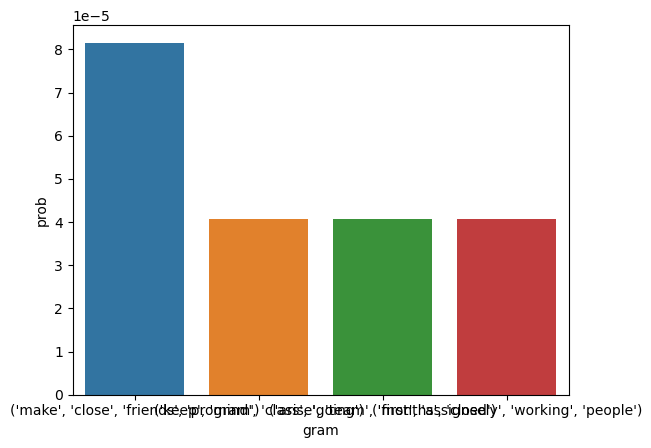

In [324]:
sns.barplot(top[:4], x='gram', y='prob')